In [1]:
import sys
sys.path.insert(1, '../../../utils')
from numpy import log, ndarray, array, mean
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller

In [2]:
from pandas import to_datetime


target = "Inflation Rate (%)"
chart_target="inflation"
filename = "../data/raw/economic_indicators_dataset_2010_2023.csv"
file_tag = "inflation"
data: DataFrame = read_csv(filename, na_values="")
data["Date"] = to_datetime(data["Date"])
data = data.set_index("Date").sort_index()
usa_data = data[data["Country"] == "USA"]
series: Series = usa_data[target]

series.head()


Date
2010-01-31    7.46
2010-02-28    3.13
2010-03-31    7.20
2010-06-30    5.56
2011-01-31    0.09
Name: Inflation Rate (%), dtype: float64

**Dimensionality**

Nr. Records =  57
First date 2010-01-31 00:00:00
Last date 2023-09-30 00:00:00


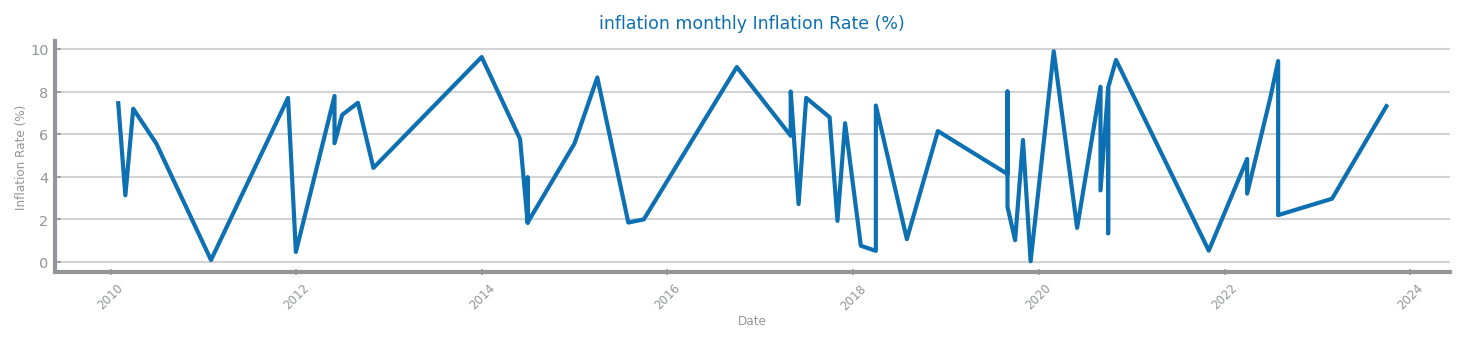

In [3]:
print("Nr. Records = ", series.shape[0])
print("First date", series.index[0])
print("Last date", series.index[-1])

fig = figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} monthly {target}",
)
save_path = f"../charts/lab5/profiling/{chart_target}_dimensionality.png"
fig.savefig(save_path)
show()

**Granularity**

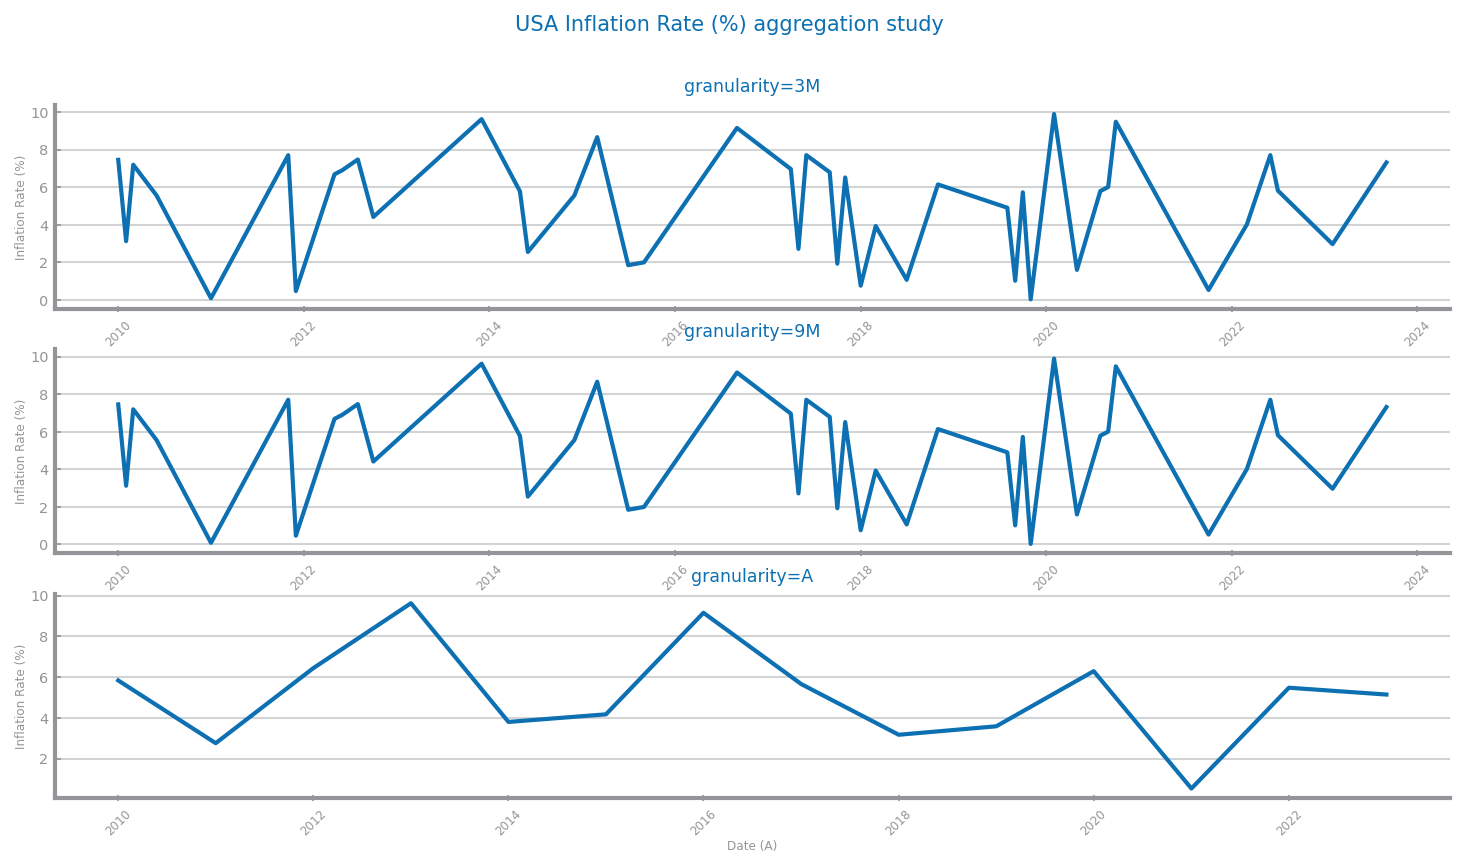

In [4]:
grans: list[str] = ["3M", "9M", "A"]

fig: Figure
axs: list[Axes]
fig, axs = subplots(len(grans), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(grans)))
fig.suptitle(f"USA {target} aggregation study")

for i in range(len(grans)):
    ss: Series = ts_aggregation_by(series, grans[i])
    plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"granularity={grans[i]}",
    )

save_path = f"../charts/lab5/profiling/{chart_target}_granularity.png"
fig.savefig(save_path)

show()

**Distribution**

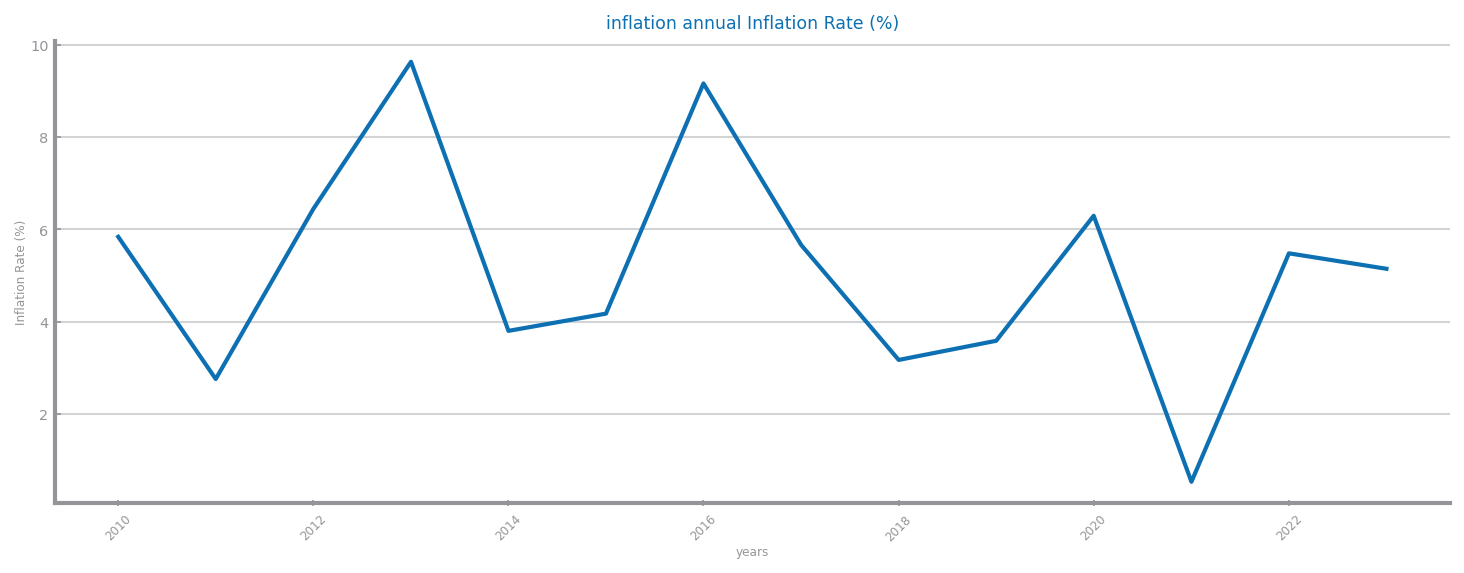

In [5]:
series_annual = ts_aggregation_by(series, gran_level="A", agg_func=mean)
fig = figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series_annual.index.to_list(),
    series_annual.to_list(),
    xlabel="years",
    ylabel=target,
    title=f"{file_tag} annual {target}",
)
save_path = f"../charts/lab5/profiling/{chart_target}_distribution_aggregation.png"
fig.savefig(save_path)
show()

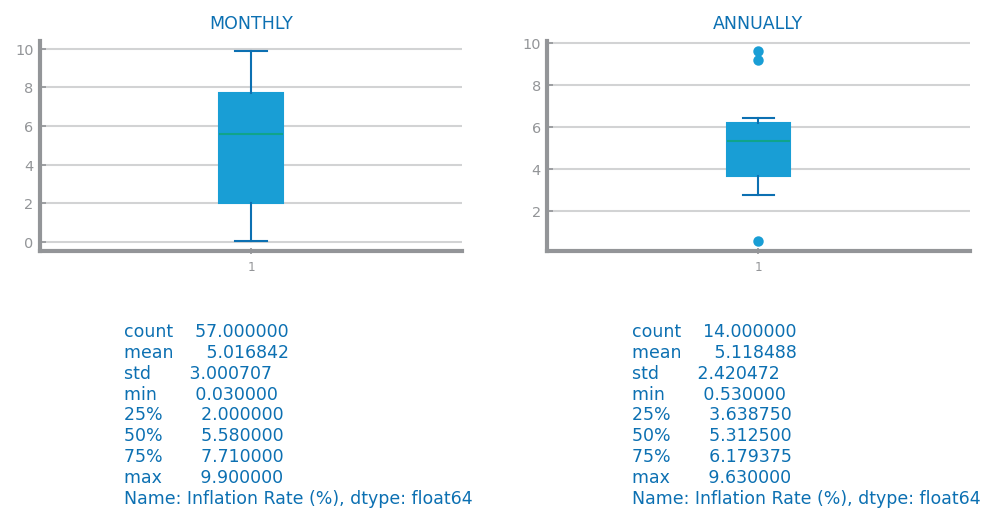

In [6]:
fig: Figure
axs: array
fig, axs = subplots(2, 2, figsize=(2 * HEIGHT, HEIGHT))
set_chart_labels(axs[0, 0], title="MONTHLY")
axs[0, 0].boxplot(series)
set_chart_labels(axs[0, 1], title="ANNUALLY")
axs[0, 1].boxplot(series_annual)

axs[1, 0].grid(False)
axs[1, 0].set_axis_off()
axs[1, 0].text(0.2, 0, str(series.describe()), fontsize="small")

axs[1, 1].grid(False)
axs[1, 1].set_axis_off()
axs[1, 1].text(0.2, 0, str(series_annual.describe()), fontsize="small")

save_path = f"../charts/lab5/profiling/{chart_target}_distribution_5number_summary.png"
fig.savefig(save_path)
show()


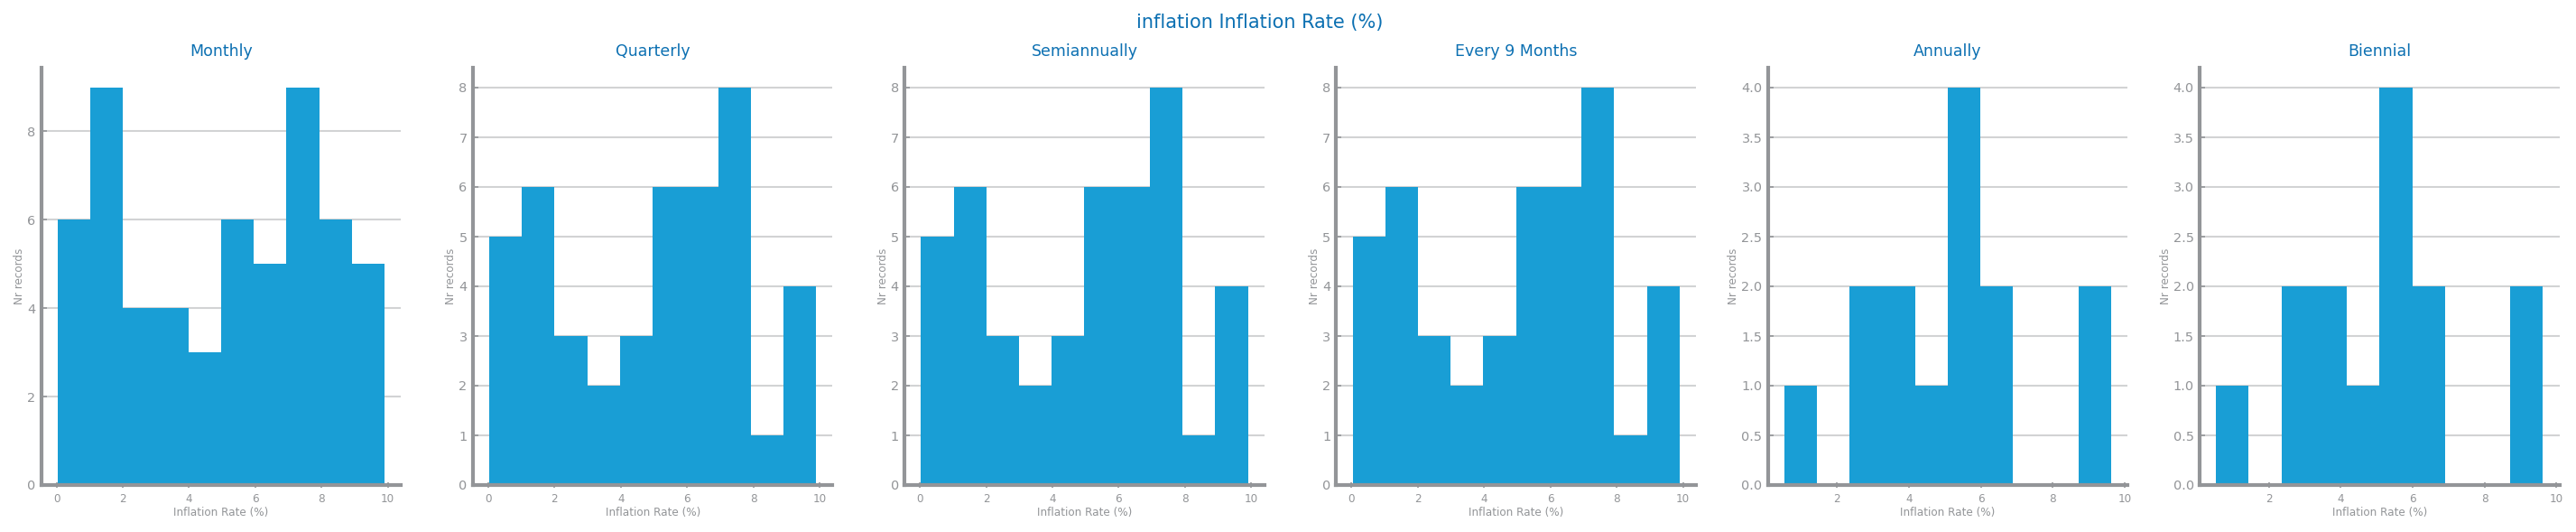

In [7]:
series_3M: Series = ts_aggregation_by(series, gran_level="3M", agg_func=mean)
series_6M: Series = ts_aggregation_by(series, gran_level="6M", agg_func=mean)
series_9M: Series = ts_aggregation_by(series, gran_level="9M", agg_func=mean)
series_2A: Series = ts_aggregation_by(series, gran_level="2A", agg_func=mean)

grans: list[Series] = [series, series_3M, series_6M, series_9M, series_annual, series_2A]
gran_names: list[str] = ["Monthly", "Quarterly", "Semiannually", "Every 9 Months", "Annually", "Biennial"]

fig: Figure
axs: array
fig, axs = subplots(1, len(grans), figsize=(len(grans) * HEIGHT, HEIGHT))
fig.suptitle(f"{file_tag} {target}")
for i in range(len(grans)):
    set_chart_labels(axs[i], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[i].hist(grans[i].values)

save_path = f"../charts/lab5/profiling/{chart_target}_distribution_variables_histogram.png"
fig.savefig(save_path)

show()



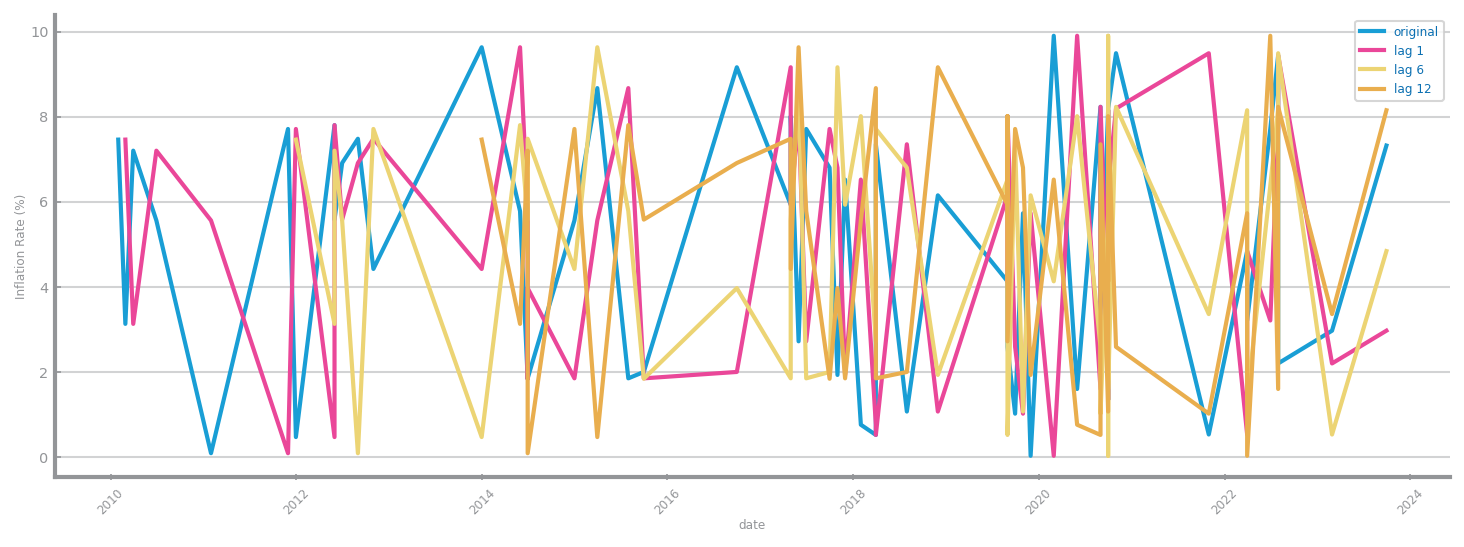

In [8]:
index="date"
def get_lagged_series(series: Series, max_lag: int, delta: int = 1):
    lagged_series: dict = {"original": series, "lag 1": series.shift(1)}
    for i in range(delta, max_lag + 1, delta):
        lagged_series[f"lag {i}"] = series.shift(i)
    return lagged_series


fig = figure(figsize=(3 * HEIGHT, HEIGHT))
lags = get_lagged_series(series, 12, 6)
plot_multiline_chart(series.index.to_list(), lags, xlabel=index, ylabel=target)

save_path = f"../charts/lab5/profiling/{chart_target}_dimensionality_autocorrelation_plot.png"
fig.savefig(save_path)

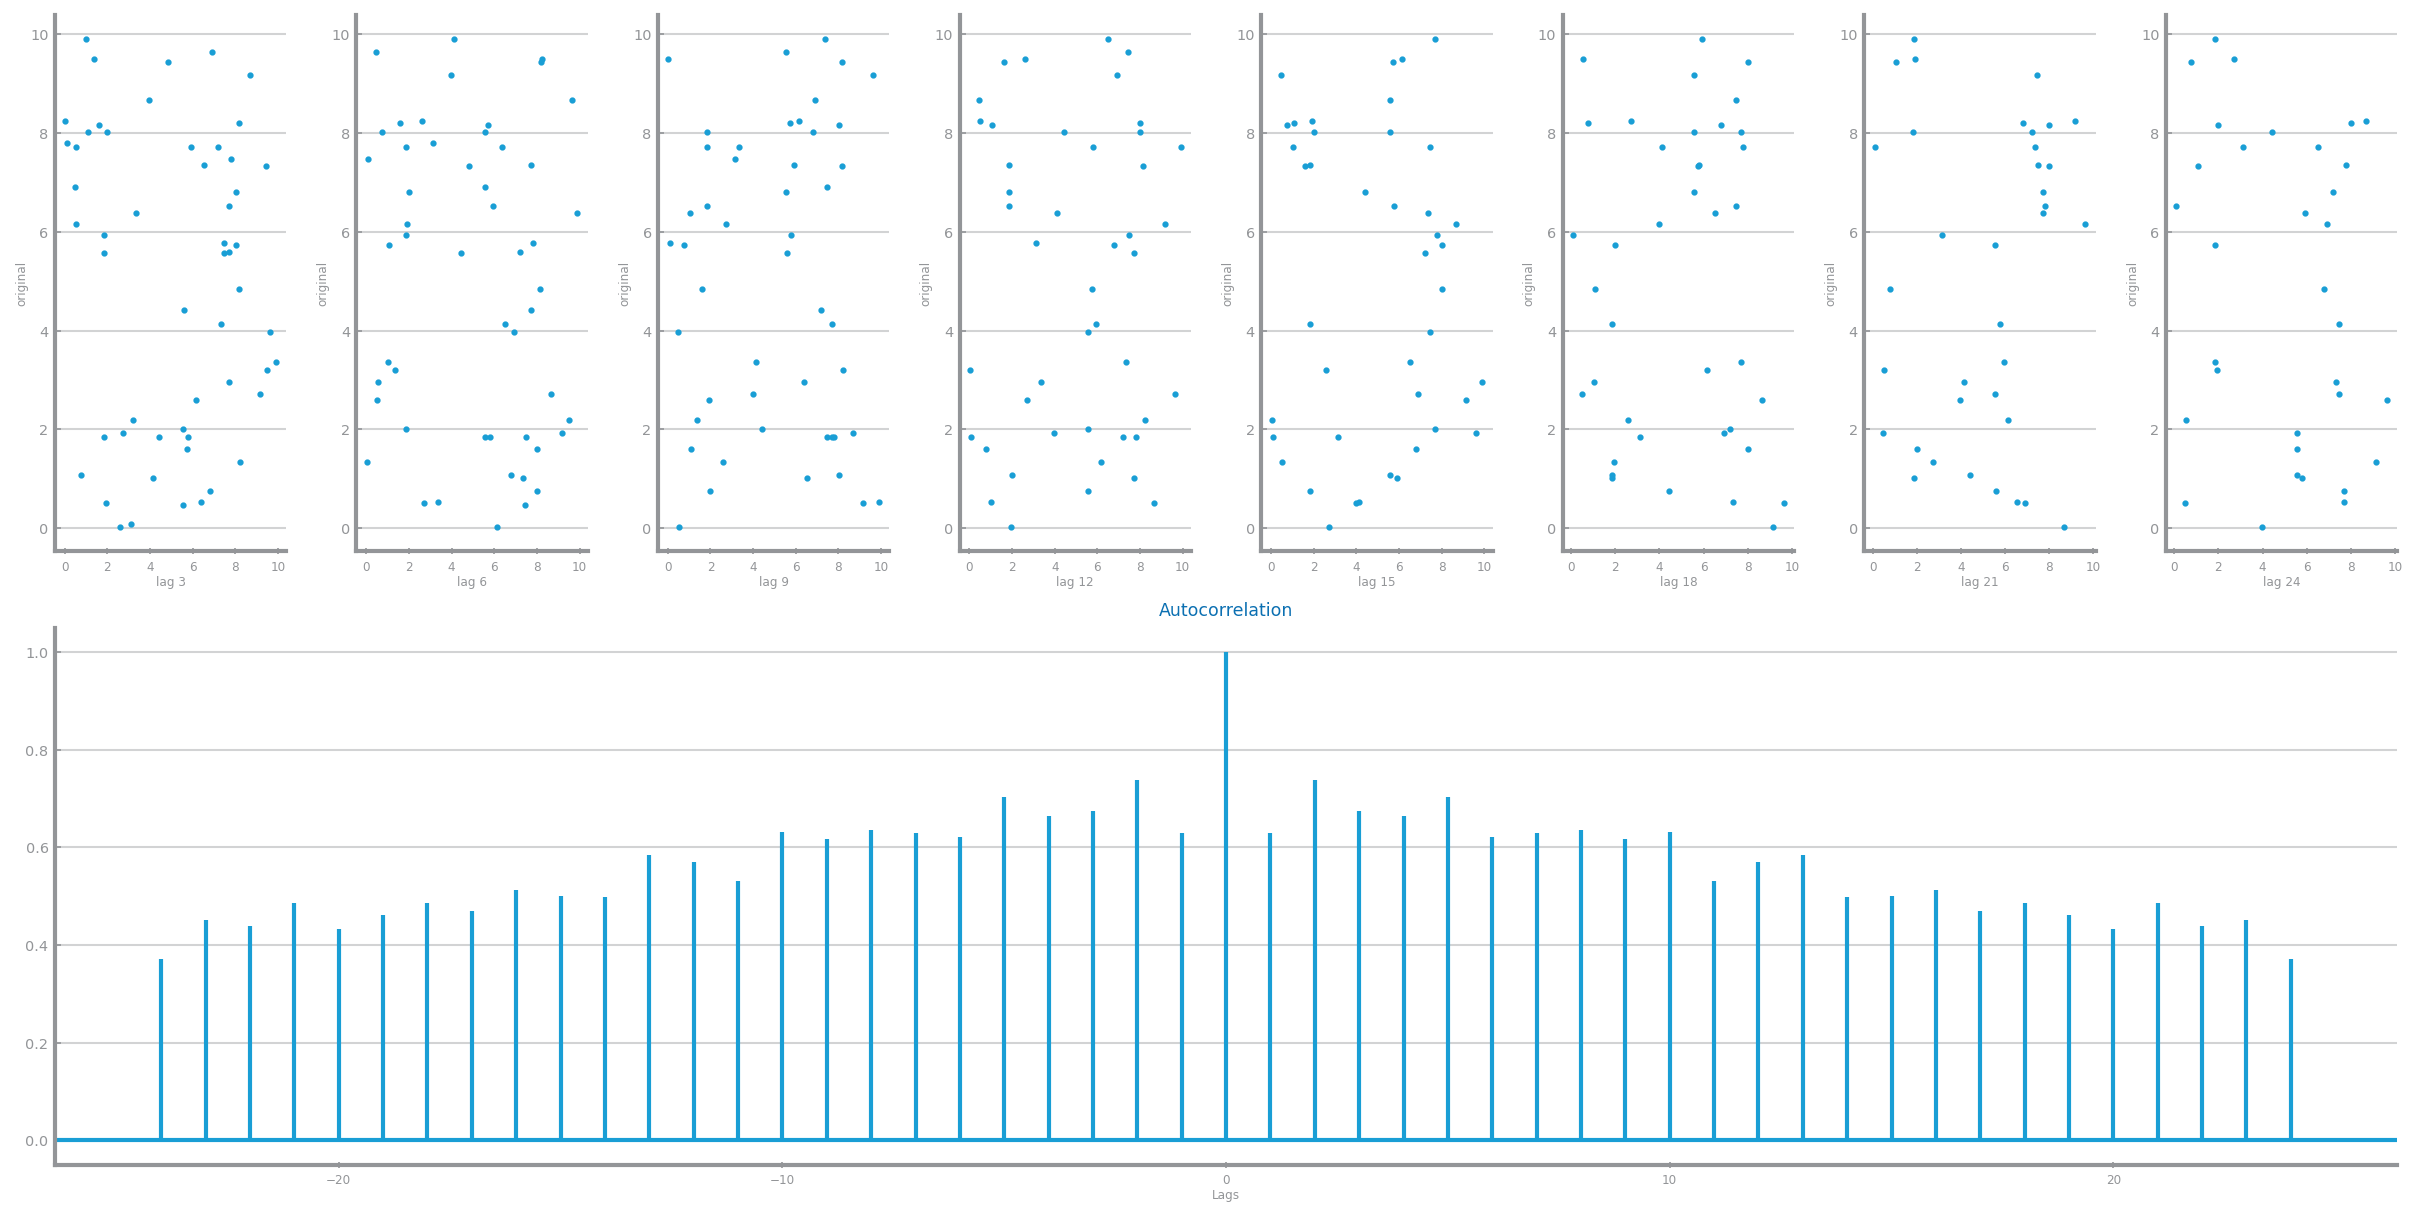

In [9]:
def autocorrelation_study(series: Series, max_lag: int, delta: int = 1):
    k: int = int(max_lag / delta)
    fig = figure(figsize=(4 * HEIGHT, 2 * HEIGHT), constrained_layout=True)
    gs = GridSpec(2, k, figure=fig)

    series_values: list = series.tolist()
    for i in range(1, k + 1):
        ax = fig.add_subplot(gs[0, i - 1])
        lag = i * delta
        ax.scatter(series.shift(lag).tolist(), series_values)
        ax.set_xlabel(f"lag {lag}")
        ax.set_ylabel("original")
    ax = fig.add_subplot(gs[1, :])
    ax.acorr(series, maxlags=max_lag)
    ax.set_title("Autocorrelation")
    ax.set_xlabel("Lags")

    return fig


fig = autocorrelation_study(series, 24, 3)
save_path = f"../charts/lab5/profiling/{chart_target}_dimensionality_autocorrelation_study.png"
fig.savefig(save_path)


**Seasonality and Stationarity**

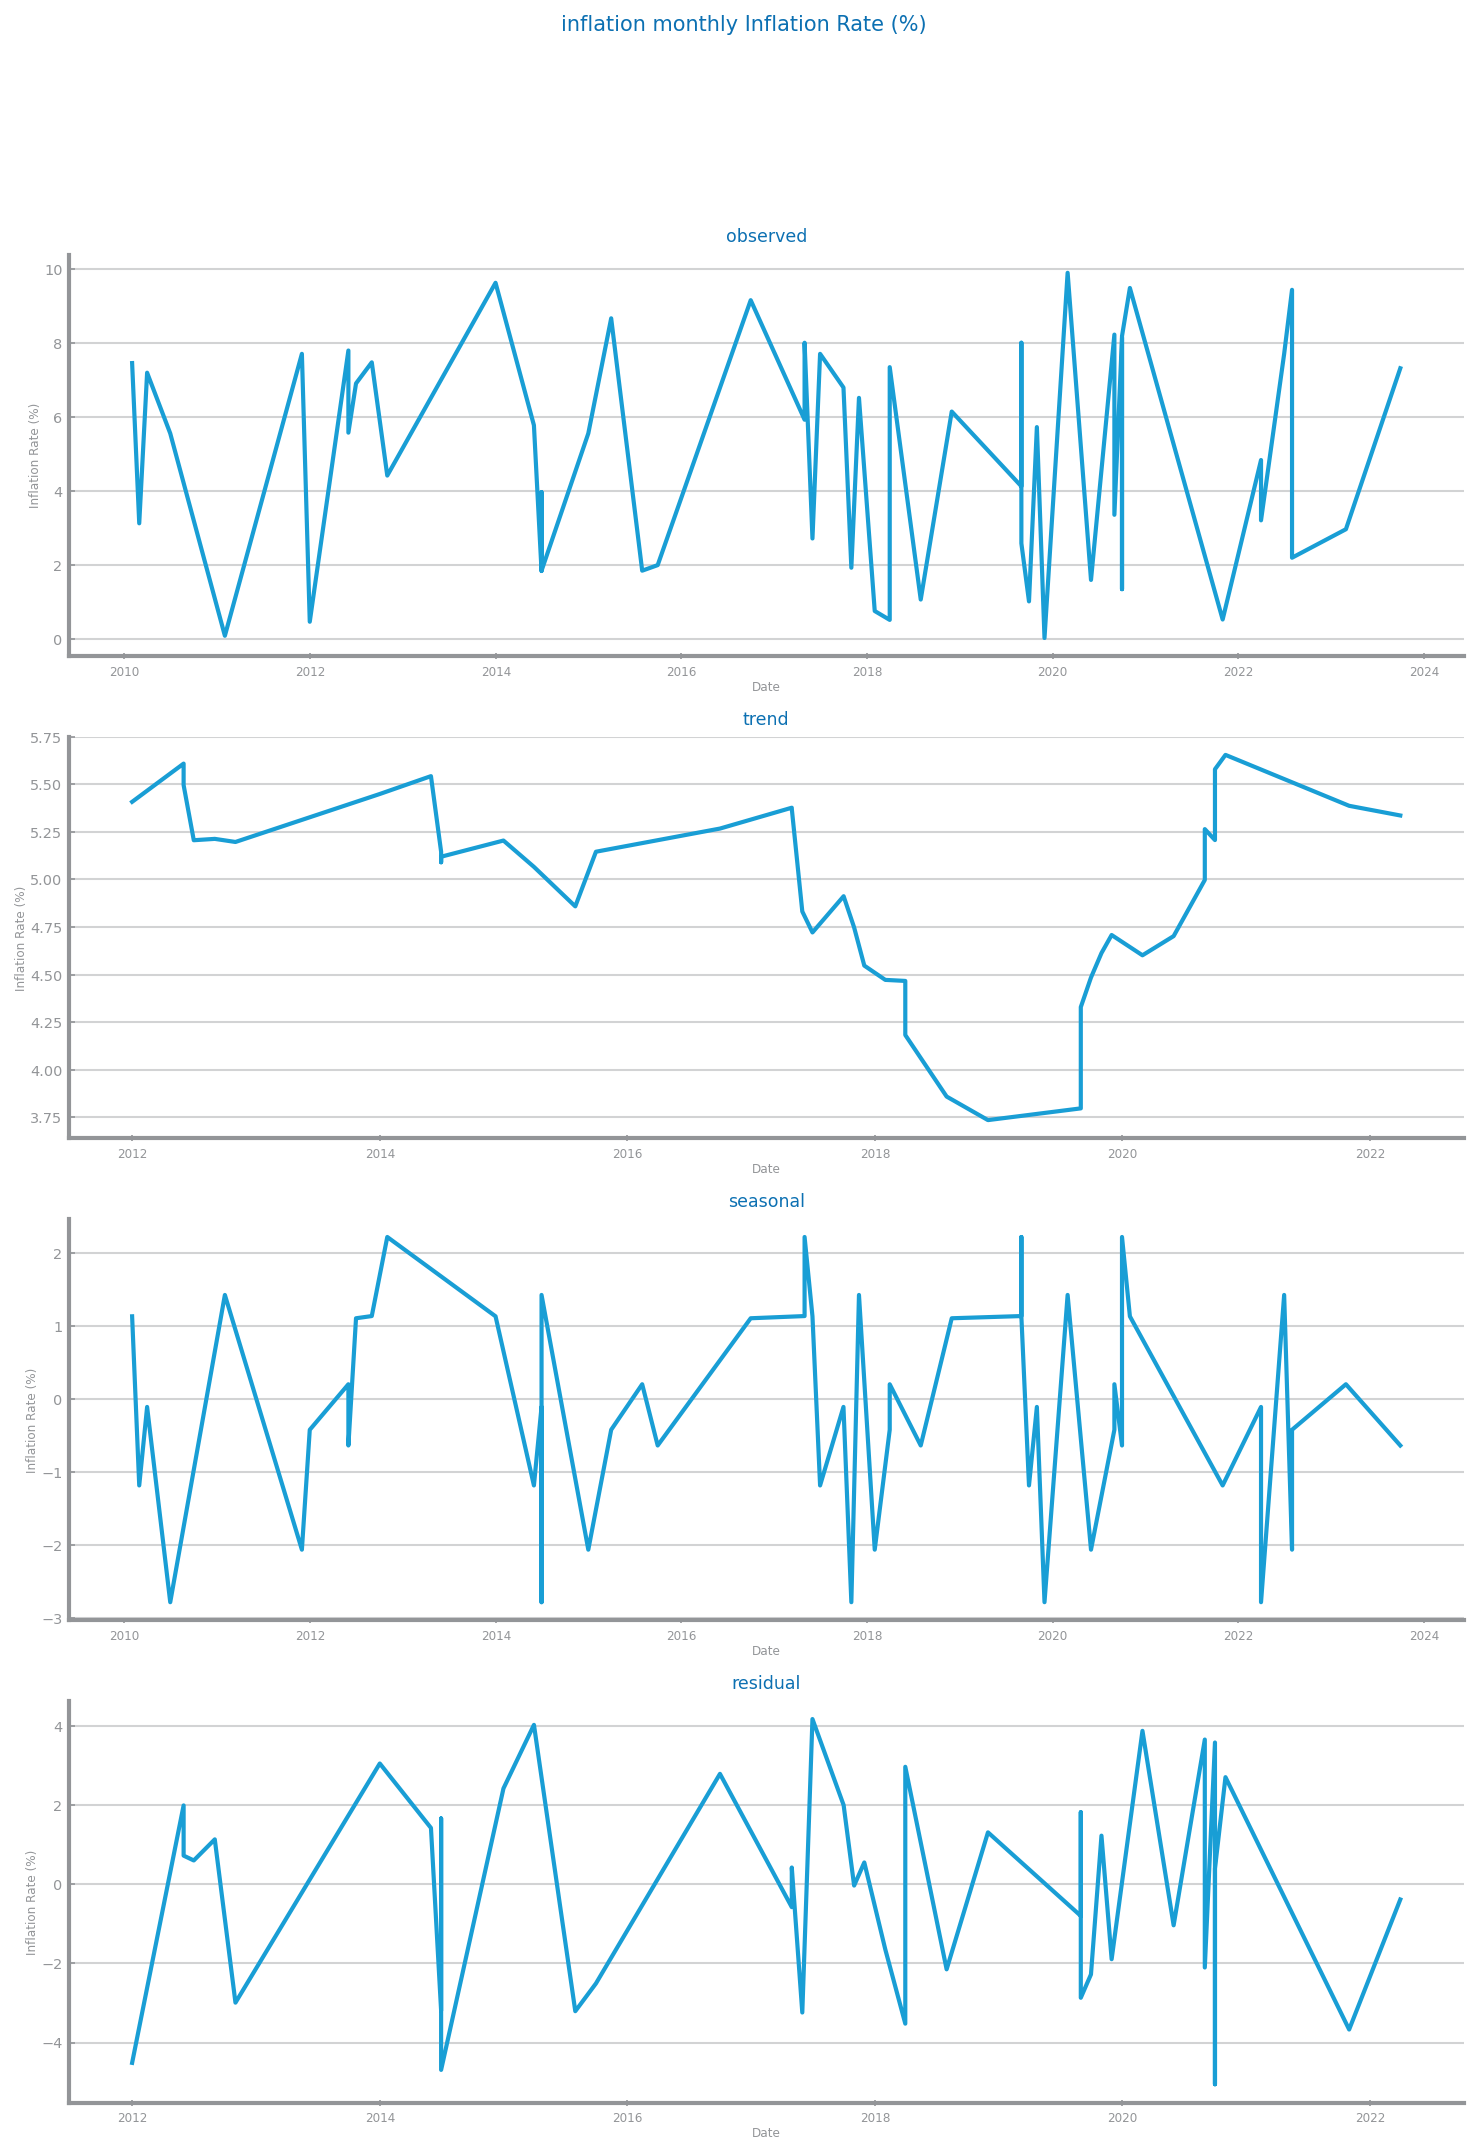

In [10]:
fig, axs = plot_components(
    series,
    title=f"{file_tag} monthly {target}",
    x_label=series.index.name,
    y_label=target,
    period=12,  
)
save_path = f"../charts/lab5/profiling/{chart_target}_seasonality_components.png"
fig.savefig(save_path)
show()

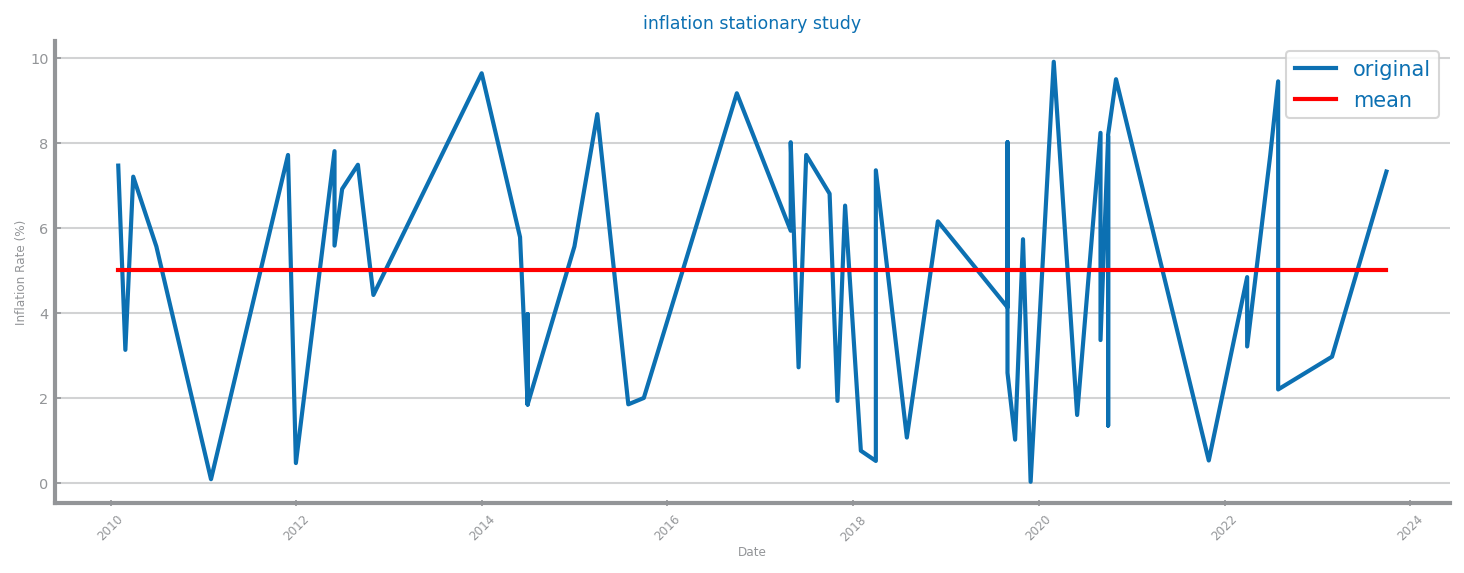

In [11]:
fig = figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
)
n: int = len(series)
plot(series.index, [series.mean()] * n, "r-", label="mean")
legend()

save_path = f"../charts/lab5/profiling/{chart_target}_stationarity_study.png"
fig.savefig(save_path)
show()


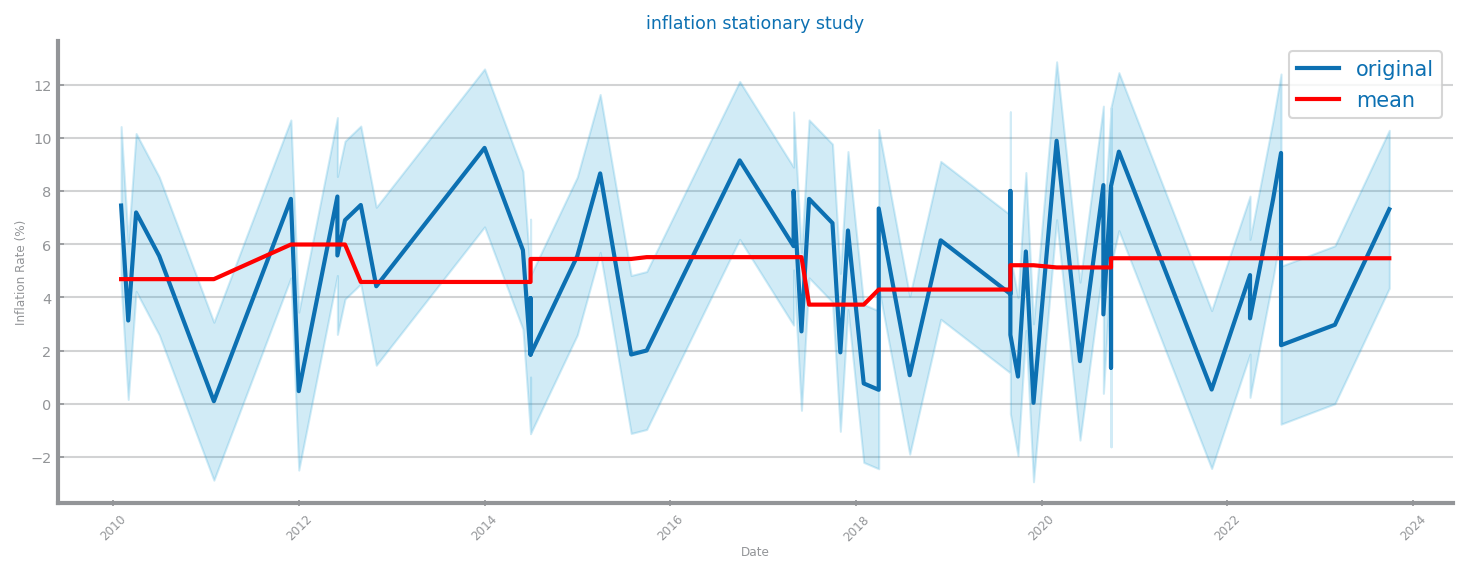

In [12]:
BINS = 10
mean_line: list[float] = []

for i in range(BINS):
    segment: Series = series[i * n // BINS : (i + 1) * n // BINS]
    mean_value: list[float] = [segment.mean()] * (n // BINS)
    mean_line += mean_value
mean_line += [mean_line[-1]] * (n - len(mean_line))

fig = figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
    show_stdev=True,
)
n: int = len(series)
plot(series.index, mean_line, "r-", label="mean")
legend()

save_path = f"../charts/lab5/profiling/{chart_target}_stationarity_study_bins.png"
fig.savefig(save_path)

show()

In [13]:
def eval_stationarity(series: Series) -> bool:
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    return result[1] <= 0.05


print(f"The series {('is' if eval_stationarity(series) else 'is not')} stationary")

ADF Statistic: -10.410
p-value: 0.000
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
The series is stationary
